In [1]:
import csv
from movies.constants import SEED
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
movies = pd.read_csv('movies_embeddings_node2vec_BFS_10_60.csv', index_col='id', quoting=csv.QUOTE_ALL)
movies.embedding = movies.embedding.apply(lambda embedding: eval(embedding))

# Visualization

In [3]:
pca = PCA(n_components=2, random_state=SEED)
principal_components = pca.fit_transform(np.array(movies.embedding.tolist()))

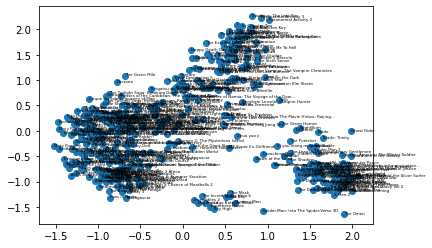

In [6]:
plt.scatter(principal_components[:, 0], principal_components[:, 1])

for index, row in movies.iterrows():
    plt.annotate(row.title, (principal_components[index, 0], principal_components[index, 1]), fontsize=4)

plt.show()

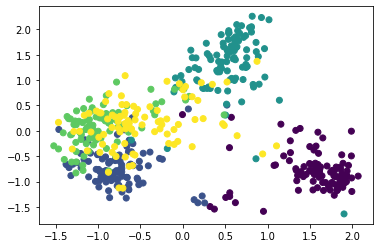

In [5]:
movies_labels = {label:index for index, label in enumerate(movies.label.unique())}
movies_colours = movies.label.map(movies_labels)

plt.scatter(principal_components[:, 0], principal_components[:, 1], c=movies_colours)
plt.show()

# Similarity

In [7]:
cos_similarity = cosine_similarity(np.array(movies.embedding.tolist()), np.array(movies.embedding.tolist()))

In [8]:
movies_index = 423
print(movies.iloc[movies_index].title)

closest_movies = cos_similarity[movies_index].argsort()[-6:][::-1]
for closest_movie in closest_movies[1:]:
    print(movies.iloc[closest_movie].title, cos_similarity[movies_index, closest_movie])

Harry Potter and the Deathly Hallows: Part I
Harry Potter and the Deathly Hallows: Part II 0.840525100248706
Fantastic Beasts: The Crimes of Grindelwald 0.8254890184082065
Harry Potter and the Half-Blood Prince 0.8100976331388994
Harry Potter and the Order of the Phoenix 0.8076035301884076
Harry Potter and the Sorcerer’s Stone 0.789356704961876


# Classification

In [9]:
X_train, X_test, y_train, y_test = train_test_split(np.array(movies.embedding.tolist()), movies_colours.to_numpy(), train_size=0.75, random_state=SEED)
logistic_classifier = LogisticRegressionCV(cv=10, scoring='accuracy', multi_class='ovr', max_iter=300, random_state=SEED)
logistic_classifier.fit(X_train, y_train)

LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', random_state=17,
                     scoring='accuracy')

In [10]:
y_pred = logistic_classifier.predict(X_test)
print(classification_report(y_test, y_pred, target_names=movies.label.unique()))

              precision    recall  f1-score   support

  super-hero       1.00      1.00      1.00        25
kids-fiction       0.95      0.81      0.88        26
      horror       0.96      1.00      0.98        22
     musical       1.00      0.91      0.95        23
     fantasy       0.81      0.96      0.88        26

    accuracy                           0.93       122
   macro avg       0.94      0.94      0.94       122
weighted avg       0.94      0.93      0.93       122

